# Домашнее задание: Seq2Seq with Attention

**Работу выполнил [Viktor Sokolov](https://stepik.org/users/190501397)**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchtext
from torchtext.legacy.data import Field, BucketIterator
from IPython.display import Markdown as md
from nltk.tokenize import WordPunctTokenizer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/
import modules 
import imp
imp.reload(modules)
from train import *

/content/drive/MyDrive/Colab Notebooks


In [4]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preparing Data

In [5]:
! wget https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ -O data.txt

--2021-03-31 18:27:33--  https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving drive.google.com (drive.google.com)... 64.233.189.138, 64.233.189.113, 64.233.189.139, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6knioqubuiq6uoc9gsh8p58ak5jicqlq/1617215250000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ [following]
--2021-03-31 18:27:35--  https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6knioqubuiq6uoc9gsh8p58ak5jicqlq/1617215250000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connecting to doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)|108.17

In [6]:
tokenizer_W = WordPunctTokenizer()

def tokenize_ru(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())[::-1]

def tokenize_en(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [7]:
SRC = Field(tokenize=tokenize_ru,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


dataset = torchtext.legacy.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [8]:
print(len(dataset.examples))
print(dataset.examples[0].src)
print(dataset.examples[0].trg)

50000
['.', 'собора', 'троицкого', '-', 'свято', 'от', 'ходьбы', 'минутах', '3', 'в', ',', 'тбилиси', 'в', 'расположен', 'cordelia', 'отель']
['cordelia', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.']


In [9]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [10]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [11]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 14166
Unique tokens in target (en) vocabulary: 10136


In [12]:
print(vars(train_data.examples[9]))

{'trg': ['rijeka', 'airport', 'is', 'located', '164', 'km', 'away', '.'], 'src': ['.', 'км', '164', 'в', 'находится', 'риеки', 'аэропорт']}


In [13]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key= lambda x: len(x.src)
)

## Model

In [14]:
Encoder = modules.Encoder
Attention = modules.Attention
Decoder = modules.DecoderWithAttention
Seq2Seq = modules.Seq2Seq

In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
BIDIRECTIONAL = True
TEMPERATURE = 3

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, (HID_DIM // 2) * (1 + (not BIDIRECTIONAL)), N_LAYERS, ENC_DROPOUT, BIDIRECTIONAL)
attention = Attention(HID_DIM, TEMPERATURE)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attention)
model = Seq2Seq(enc, dec, device).to(device)

In [16]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14166, 300)
    (rnn): LSTM(300, 256, num_layers=2, dropout=0.1, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=True)
    )
    (embedding): Embedding(10136, 300)
    (rnn): GRU(812, 512, num_layers=2, dropout=0.1)
    (out): Linear(in_features=1324, out_features=10136, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

md('The model has **{:,}** trainable parameters'.format(count_parameters(model)))

The model has **27,578,529** trainable parameters

## Training

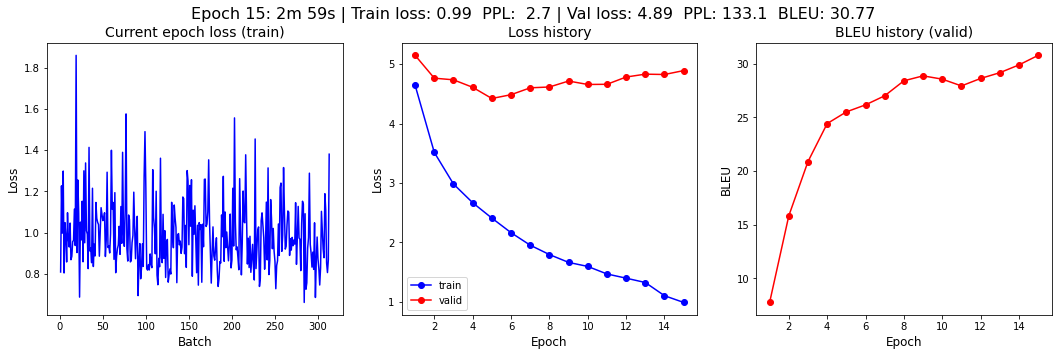

In [18]:
N_EPOCHS = 15
CLIP = 5
TF_RATIO = 0.5

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=13, gamma=0.1)
criterion = nn.CrossEntropyLoss(ignore_index = TRG.vocab.stoi['<pad>'])

log = education(model, optimizer, scheduler, criterion, TRG.vocab, train_iterator, valid_iterator, N_EPOCHS, CLIP, TF_RATIO)

## Control quality

In [19]:
model.load_state_dict(torch.load('best-val-model.pt'))
(trg, src), _ = next(iter(test_iterator))
generate_translation(src, trg, model, TRG.vocab)

Original: a tv is featured .
Generated: a tv is offered .

Original: the bathroom has a shower .
Generated: the bathroom comes with a shower .

Original: bed linen is featured .
Generated: bed linen bed linen .

Original: guests can enjoy the on - site restaurant .
Generated: guests can enjoy the on - site restaurant .

Original: the property offers free parking .
Generated: the property offers free parking .

Original: the unit is fitted with a kitchen .
Generated: the unit is equipped with a kitchen .

Original: the beds are with a mosquito net .
Generated: fan and bunk beds .

Original: the hotel offers a 24 - hour front desk .
Generated: there is a 24 - hour front desk at the property .

Original: the property offers free parking .
Generated: the property offers free parking .

Original: breakfast is available as well .
Generated: breakfast is available .



In [20]:
bleu = bleu_metric(test_iterator, model, TRG.vocab)
md('**Bleu: {}**'.format(round(bleu, 2)))

**Bleu: 31.07**



---

